# Step 2 - calculate zeta using FERENGI data
# Measure and parameterize dropoff in $f_{features}$ for FERENGI-fied images in Galaxy Zoo: Hubble

In [26]:
%matplotlib inline

from matplotlib import pyplot as plt
from astropy.table import Table,Column
from astropy.io import fits
from scipy import optimize
from scipy.stats import distributions as dist
import numpy as np
import os
import requests
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=UserWarning, append=True)

In [27]:
# Load data from Dropbox folder instead of clogging up Github

def download_from_dropbox(url):
    
    local_filename = "../{:}".format(url.split("/")[-1].split("?")[0])
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
            
    return local_filename

In [ ]:
# Use only galaxies with surface brightness/redshift ranges that are considered "debiasable"
# This table is computed in STEP 1 - p_features_thresholds_slope_method.ipynb

ferengi_filename = download_from_dropbox("https://www.dropbox.com/s/e094o8z7dxkkciq/ferengi_data_with_categories_new_sb.fits?dl=1")
alldata = Table.read(ferengi_filename)    

data = alldata[alldata['Correctable_Category'] == 'correctable']

# Limit to galaxies that have data at z_sim = z0, since that's what we're normalizing to.
z0 = 0.3
unique_galaxies = set(data['sdss_id'])
z0ind = np.zeros(len(data),dtype=bool)
eps = 1e-3
for ug in unique_galaxies:
    ind = (data['sdss_id'] == ug)
    if data[ind]['sim_redshift'].min() < (z0+eps):
        z0ind[ind] = True
        
data_z0 = data[z0ind]

##### "Zeta method"

Assume that the change in $f_{features}$ as a function of redshift can be parameterized as:

$\frac{f_f}{f_{f,z=z_0}} = e^{-\frac{(z-z_0)}{\zeta}}$

where $z_0=0.3$ is the lowest redshift in the FERENGIed images.

In [48]:
def fzeta_exp(p,x):
    
    #y = p[0] * np.exp(-1 * (x-p[1])/p[2])
    
    y = np.exp(-1 * (x-z0)/p[0])

    return y
    
def fzeta_lin(p,x):
    
    y = p[0] + p[1] * x

    return y

def fzeta(p,x):
    
    # Results are qualitatively the same for both lin and exp versions (should show this explicitly)
    # Use the exponential version for now.
    
    return fzeta_exp(p,x)

def errfunc(p,x,y,s):
    
    err = (y - fzeta(p,x))/s

    return err

def errfunc_lin(p,x,y,s):
    
    err = (y - fzeta_lin(p,x))/s

    return err

def error_bars(k,n=40,c=0.683):

    f_gal_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    f_gal_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    f_gal_err = (f_gal_upper - f_gal_lower) / 2.0
    
    return f_gal_err

def common_labels(fig,xlabel=None,ylabel=None,xfontsize=12,yfontsize=12):

    # Set common labels
    cax = fig.add_subplot(111)    # The big subplot
    cax.set_axis_bgcolor('none')
    cax.spines['top'].set_color('none')
    cax.spines['bottom'].set_color('none')
    cax.spines['left'].set_color('none')
    cax.spines['right'].set_color('none')
    cax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    cax.set_xlabel(xlabel,fontsize=xfontsize)
    cax.set_ylabel(ylabel,fontsize=yfontsize)

    return cax

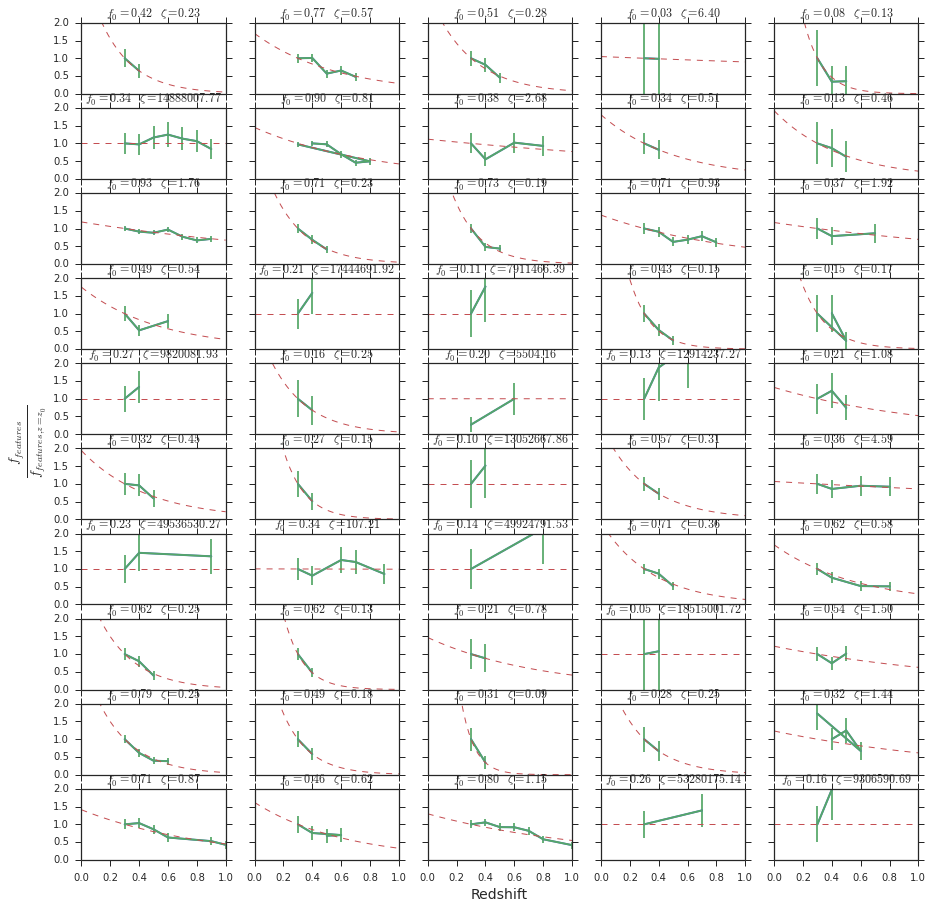

In [49]:
p_guess = np.array([0.5])

# Set up plot
fig,axarr = plt.subplots(nrows=10,ncols=5,sharex=True,sharey=True,figsize=(15,15))
bigax = common_labels(fig,'Redshift',r'$\frac{f_{features}}{f_{features,z=z_0}}$',14,20)
zarr = np.linspace(0,1,50)

# For examples, only plot galaxies with an evolution correction of zero.
evol = 0.0
e0 = data_z0[np.absolute(data_z0['sim_evolution'] - evol) < 0.001]
unique_galaxies = set(e0['sdss_id'])

for ax in axarr.ravel():
    
    slen = 0
    # Make sure there are enough points to fit a function
    while slen < (len(p_guess)+1):
        ind = (e0['sdss_id'] == unique_galaxies.pop())
        slen = sum(ind)
        
    galaxy1 = e0[ind]

    z_gal = galaxy1['sim_redshift']
    f_gal = galaxy1['p_features']
    
    #  ADD ERROR BARS
    n = 40  # assume 40 classifications per galaxy; it'd be better to use true value, though
    f_gal_err = error_bars(f_gal*n,n)
    f_gal_norm = f_gal / f_gal[0]
    f_gal_norm_err = np.sqrt((f_gal_err/f_gal)**2 + (f_gal_err[0]/f_gal[0])**2) * f_gal_norm

    # Values must be explicitly cast as double-type precision for optimization to work. Incredibly frustrating.
    # Fix: http://stackoverflow.com/questions/12473406/scipy-optimize-leastsq-returns-best-guess-parameters-not-new-best-fit 

    p, cov, infodict, mesg, ier = optimize.leastsq(errfunc,p_guess,args=(z_gal.astype(np.float64),
                                                                         f_gal_norm.astype(np.float64),
                                                                         f_gal_norm_err.astype(np.float64)),
                                                   full_output=1)
    ax.plot(z_gal,f_gal_norm,lw=2)
    ax.errorbar(z_gal,f_gal_norm, f_gal_norm_err)
    ax.plot(zarr,fzeta_exp(p,zarr),'--',lw=1)
    ax.set_title('$f_0={:.2f}\; \zeta={:.2f}$'.format(f_gal[0], p[0]))
    ax.set_xlim(0,1)
    ax.set_ylim(0,2)

In [50]:
# Find zeta for all images
evol = 2.0
e0 = data_z0[np.absolute(data_z0['sim_evolution'] - evol) < 0.001]
unique_galaxies = set(e0['sdss_id'])

#unique_galaxies = set(data_z0['sdss_id'])

data_z0['zeta'] = np.ones(len(data_z0)) * -99
data_z0['delchisq'] = np.ones(len(data_z0)) * -99

for gal in unique_galaxies:
    
    # Loop over evolution corrections
    
    for evo in set(data_z0['sim_evolution']):
        
        # Find data for this galaxy at all redshifts
        
        ind = (data_z0['sdss_id'] == gal) & (np.absolute(data_z0['sim_evolution'] - evo) < 0.001)
        
        # Make sure there are enough points to fit a function
        if sum(ind) > 3:
        
            galaxy1 = data_z0[ind]
            
            z_gal = galaxy1['sim_redshift']
            f_gal = galaxy1['p_features']
            
            #  ADD SOME ROUGH ERROR BARS
            f_gal_err = error_bars(f_gal*n,n)
            f_gal_norm = f_gal / f_gal[0]
            f_gal_norm_err = np.sqrt((f_gal_err/f_gal)**2 + (f_gal_err[0]/f_gal[0])**2) * f_gal_norm
            
            try:
                p, cov = optimize.leastsq(errfunc,p_guess,args=(z_gal.astype(np.float64),f_gal_norm.astype(np.float64),
                                                                f_gal_norm_err.astype(np.float64)))
                zeta = p[0]
                chisq = (((f_gal_norm - fzeta(p,z_gal)) / f_gal_norm_err)**2).sum()
                chisq_const = (((f_gal_norm - f_gal_norm.mean()) / f_gal_norm_err)**2).sum()
                delchisq = chisq_const - chisq
            except TypeError:
                print 'Galaxy %s has only %i redshifted images' % (galaxy1['sdss_id'][0],len(z_gal))
                zeta = -99.
                
            # Add zeta values to the larger table
            data_z0['zeta'][ind] = p[0]
            data_z0['delchisq'][ind] = delchisq

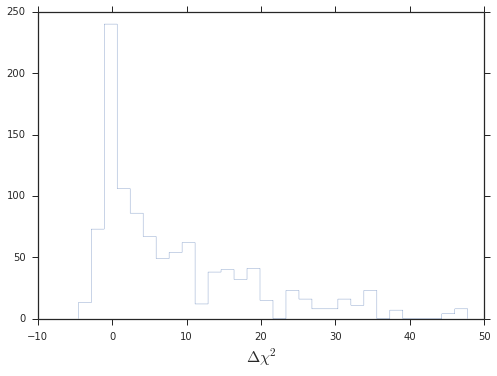

In [51]:
# Plot the distribution of delta chi^2
_ = plt.hist(data_z0['delchisq'][data_z0['delchisq']>-5], 30, histtype='step')
plt.xlabel(r"$\Delta \chi^2$",fontsize=16);

In [52]:
# How many galaxies have well-measured zeta values?

print '%i galaxies have well-measured zeta values' % ((data_z0['zeta'] < 10.) & (data_z0['zeta'] > -99.)).sum()
print '%i galaxies have zeta = -99' % (data_z0['zeta'] == -99.).sum()
print len(data_z0['zeta'])

934 galaxies have well-measured zeta values
626 galaxies have zeta = -99
1690


92 (27 unique) galaxies with measured zeta values.



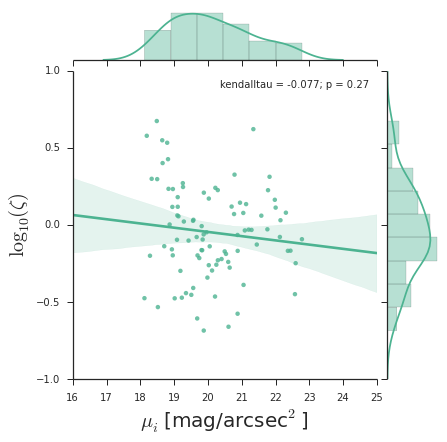

In [53]:
# Plot distribution of zeta as function of surface brightness
from scipy.stats import kendalltau
import seaborn as sns

sns.set(style="ticks")

# Only select unique galaxies (zeta is the same for all evolution corrections)

dz3 = data_z0[(data_z0['sim_redshift'] == z0) & (data_z0['p_features'] >= 0.0) & (data_z0['delchisq'] > 3.0)]

# Limit zeta to "sensible" values
zetalim = dz3[(dz3['zeta'] < 10.) & (dz3['zeta'] > -98.)]
x = zetalim['GZ_MU_I']
y = np.log10(zetalim['zeta'])
print "%i (%i unique) galaxies with measured zeta values.\n" % (len(zetalim),len(set(zetalim['sdss_id'])))

jg = sns.jointplot(x, y, kind="reg", stat_func=kendalltau, color="#4CB391")
jg.set_axis_labels(r'$\mu_{i}$ [mag/arcsec$^2$]',r'$\log_{10}(\zeta)$',fontsize=20);
plt.ylim(-1,1)
plt.savefig('../../writeup/figures/zeta_mu.pdf')

In [54]:
fit = jg.ax_joint.lines[0].get_data()
x0,y0 = fit[0][0],fit[1][0]
x1,y1 = fit[0][-1],fit[1][-1]

# Slope, intercept where x = SB, y = log_10(zeta)
slope = (y1-y0)/(x1-x0)
intercept = y1 - slope*x1

$\log_{10}\zeta = m\mu + b$

$\zeta = 10^{m\mu + b}$

In [55]:
print('zeta = {:.1f} is a reasonable first order correction'.format(10**y.mean()))
print('For a slightly improved correction, fit with the linear function such that log_10(zeta) = ({:.4f} * SB) + {:.4f}'.format(slope,intercept))

zeta = 0.9 is a reasonable first order correction
For a slightly improved correction, fit with the linear function such that log_10(zeta) = (-0.0274 * SB) + 0.5035


# Output Zeta parameters
## used in STEP 4 - when applying zeta function to debiase data

In [56]:
#create fits file of lower and upper limits for p_features
c1 = Column([slope], name='slope') 
c2 = Column([intercept], name='intercept')
c3 = Column([10**y.mean()], name='first_order_correction')

zeta_table = Table()  
zeta_table.add_columns([c1,c2,c3])

#Set path for output
fname = '/home/mel/Dropbox/gzhubble/hubble_files/catalog_debiasing_files/new_sb_method/zeta_parameters.fits'
if os.path.exists(fname):
    os.remove(fname)
zeta_table.write(fname,format='fits')